In [1]:
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt


#first a class to form a naive wave
class waveGen:
    
    def __init__(self, freq, BufferSize, waveType, vol):
        
        self.sampleRate = 48000
        self.bufferSize = BufferSize
        self.buffer = np.empty(BufferSize, dtype=np.complex)
        self.frequency = freq
        self.omega = 0
        self.updateOmega()
        self.last = complex(1,0)
        self.type = waveType
        self.volume = vol
        self.sawLast = 0
        

    def sineGen(self):

        #start = timer() #reduce function!!! functools
        for i in range(0, self.bufferSize):
            self.buffer[i] = self.last
            self.last=self.last*self.omega

        return self.volume * np.imag(self.buffer)#.astype(np.float32)

    def squareGen(self):
        #start = timer()
        for i in range(0, self.bufferSize):
            self.buffer[i] = self.last
            self.last=self.last*self.omega

        return np.sign(self.volume * np.imag(self.buffer)).astype(np.float32)
    
    def sawGen(self):
        wav_len = self.sampleRate / self.frequency
        half_wave_len = wav_len / 2
        
        for i in range(0, self.bufferSize):
            pos = (i + self.sawLast) % wav_len
            self.buffer[i] = ((pos / half_wave_len) - 1) * self.volume
        
        self.sawLast = (self.bufferSize + self.sawLast) % wav_len
        
        return self.buffer.astype(np.float32)
    
    def triangleGen(self):
        wav_len = self.sampleRate / self.frequency
        half_wave_len = wav_len / 2
        
        for i in range(self.bufferSize):
            self.buffer[i] = ( 2 * abs((((i + self.sawLast) % wav_len) / half_wave_len) - 1) - 1) * self.volume * -1
        
        return self.buffer.astype(np.float32)

    def updateOmega(self):
        self.omega = cmath.exp(1j*(2*cmath.pi * self.frequency / self.sampleRate))

    def updateFreq(self, val):
        self.frequency = val
        self.updateOmega()

    def nextFrame(self):
        if self.type == "sine":
            return self.sineGen()
        elif self.type == "square":
            return self.squareGen()
        elif self.type == "triangle":
            return self.triangleGen()
        elif self.type == "saw":
            return self.sawGen()

In [2]:


def poly_blep(t, dt):

  # 0 <= t < 1
    if (t <= dt): #the first
  
        t /= dt
        # 2 * (t - t^2/2 - 0.5)
        return t+t - t**2 - 1.
  

    # -1 < t < 0
    elif (t >= 1. - dt): #the last
        t = (t - 1.) / dt;
        # 2 * (t^2/2 + t + 0.5)
        return t*t + t+t + 1.

    # 0 otherwise
    else:
        return 0.
    

def poly_square(samples, freq, sample_rate):

    output = np.zeros(len(samples))
    dt = freq / sample_rate - 0.00000000000001 #0.000000000000001 this value works well 14/15 decimal places
    #
    t = .5
    
    for i in range(len(samples)):
        
        output[i] = samples[i] - poly_blep(t%1, dt)
        output[i] += poly_blep((t + .5) % 1, dt)
        
        #checking for float-overflow errors: correcting by rounding and re-calulating
        if output[i] > 1 or output[i] < -1:
            t = round(t, 1)
            output[i] = samples[i] - poly_blep(t%1, dt)
            output[i] += poly_blep((t + .5) % 1, dt)
            #checking again and printing any errors
            if output[i] > 1 or output[i] < -1:
                print("t:", t, "dt:", dt, 'at index:', i, 'freq:', freq, 'peak', output[i])
        
        t += dt
        if t > 1:
            t -= 1
    
    return output

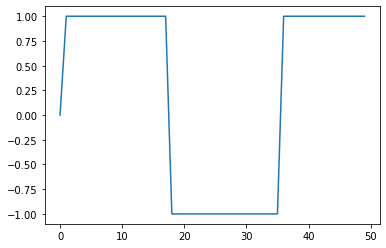

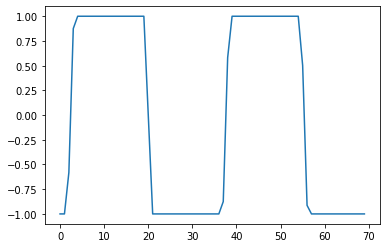

In [3]:
freq = 1360
sample_rate = 48000
length = 480000

wave = waveGen(freq, length, 'square', 1)
square = wave.nextFrame()


output = poly_square(square, freq, sample_rate)

plt.plot(square[:50])
plt.show()
plt.plot(output[280:350])
plt.show()

5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


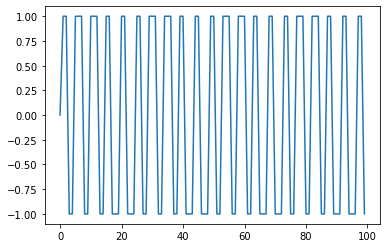

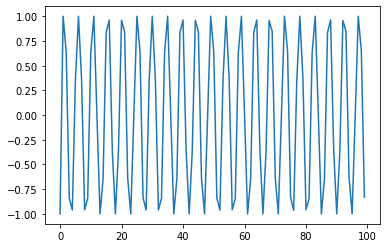

In [4]:
# 
length = 4800
for i in range(5000, 10000, 1):
    if (i % 100 == 0):
        print(i)
    wave = waveGen(i, length, 'square', 1)
    square = wave.nextFrame()
    output = poly_square(square, i, sample_rate)
            
        
plt.plot(square[:100])
plt.show()
plt.plot(output[:100])
plt.show()

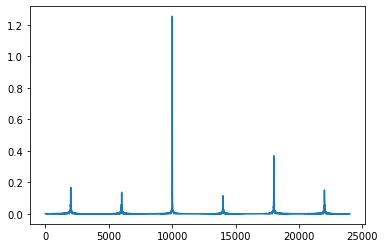

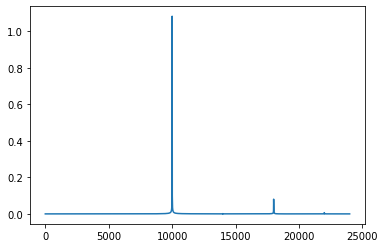

In [5]:
sqrFreqSpec = np.fft.fft(square)
outFreqSpec = np.fft.fft(output)

#linespaceing
T = 1.0 / 48000.0

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)

#ploting the graph
plt.plot(xf, 2.0/length * np.abs(sqrFreqSpec[:length//2]))
plt.show()

plt.plot(xf, 2.0/length * np.abs(outFreqSpec[:length//2]))
plt.show()

## This is probably not the fastest of algorythms but is has been tested on the generation of 1 second of audio for 1 sec on  every herz

### there theoretical might be distortion in the freq domain due to the correction of floating point rounding errors, I am yet to identify these instances and i can suppose that they are very rare